# ECBM4040  Assignment 1, Task 2: Multilayer Perceptron (MLP)
This is the second part of the assignment. You will get to know the basic fully connected neural network.

In [83]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
try:
    import _pickle as pickle
except ImportError:
    import pickle as pickle

from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [84]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers

### Create basic layer functions

<span style="color:red"><strong>TODO</strong></span>: Complete functions **affine_forward**, **affine_backward** in **./ecbm4040/layer_funcs.py**.

In [85]:
from ecbm4040.layer_funcs import affine_forward
from ecbm4040.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

# Affine function -- H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./ecbm4040/layer_funcs.py**.

In [86]:
from ecbm4040.layer_funcs import relu_forward
from ecbm4040.layer_funcs import relu_backward

# Activation layers -- Here we introduce ReLU/Leaky ReLU activation functions
# since they are the most commonly used in computer vision problems.
# However, you can also try to implement other activation functions like sigmoid, tanh etc. 
x = X_dev
dout = np.ones(x.shape)
# ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
out_tf = tf.nn.relu(x_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)[0]
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check = sess.run(dx_tf)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **softmax_loss** in **./ecbm4040/layer_funcs.py**

In [87]:
from ecbm4040.layer_funcs import softmax_loss

# generate some random data for testing
x = np.random.rand(100,10)
y = np.argmax(x, axis=1)


loss, dx = softmax_loss(x, y)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# tensorflow gradients
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= x_tf, labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy)
dx_tf = tf.gradients(loss, x)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(loss_tf, x_tf)
with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf)
    dx_check = sess.run(dx_tf)

# Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

Now try to combine an affine function and a nonlinear activation function into a single fully-connected layer. Edit the code in ./ecbm4040/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b})$$

For this assignment, you need to create two types of layers as below. You can get started with the skeleton code in ./ecbm4040/layer_utils.py. The basic class structure has been provided, and you need to fill in the "TODO" part(s). 

* DenseLayer -- Affine transform >> ReLU
```
Class DenseLayer:
    Variables: weights, bias 
    Functions: 
        __init__: given (input_dim, output_dim, weight_scale)
        feedforward: TODO
        backforward: TODO      
```    
* AffineLayer -- Affine transform >> Softmax and the class structure is similar to DenseLayer

<span style="color:red"><strong>TODO</strong></span>: Complete function **DenseLayer** in **./ecbm4040/layer_utils.py**

In [122]:
# First, let's make a dense layer
from ecbm4040.layer_utils import DenseLayer

# Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

# Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients


################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.nn.relu(tf.matmul(x_tf,w_tf) + b_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete function **AffineLayer** in **./ecbm4040/layer_utils.py**

In [89]:
from ecbm4040.layer_utils import AffineLayer

# Affine + ReLU
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

# Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: More Backpropogation

Complete the class **TwoLayerNet** in **./ecbm4040/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete class **TwoLayerNet** in **./ecbm4040/classifiers/twolayernet.py**

In [162]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

# Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=200, num_classes=10, reg=1e-5)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# Check loss by tensorflow
x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.uint8, shape=(None,))

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-5*L2_loss 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf, feed_dict={x_tf: X_dev, y_tf: y_dev})
    
# Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [91]:
from ecbm4040.train_funcs import train, test

#### Start training
<span style="color:red"><strong>TODO</strong></span>: Use previous layers to create a two layer neural network:

**input->(affine->activation)->(affine->softmax)->output**

The recommended activation function is ReLU. You can also make a comparison with other activation function to see any difference.

In [180]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=0.25, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-3
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 2.515342395381255
10000/49000 loss: 2.2696121743872673
15000/49000 loss: 2.249022449957853
20000/49000 loss: 2.2007017912302467
25000/49000 loss: 2.140042709870435
30000/49000 loss: 2.133149688844047
35000/49000 loss: 2.07246322457215
40000/49000 loss: 2.077276984245957
45000/49000 loss: 1.9986983539249197
epoch 1: valid acc = 0.275, new learning rate = 0.00095
5000/49000 loss: 1.918308185559238
10000/49000 loss: 1.8899895342949258
15000/49000 loss: 1.9001069608080232
20000/49000 loss: 1.8585208988619855
25000/49000 loss: 1.8356263631802008
30000/49000 loss: 1.8132594985059698
35000/49000 loss: 1.8128715028396143
40000/49000 loss: 1.848535357966245
45000/49000 loss: 1.8096058806335473
epoch 2: valid acc = 0.338, new learning rate = 0.0009025
5000/49000 loss: 1.7502744706879587
10000/49000 loss: 1.7221016960964721
15000/49000 loss: 1.744780936628114
20000/49000 loss: 1.7263925185952367
25000/49000 loss: 1.7125343923362353
30000/49000 l

0.35670000000000002

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

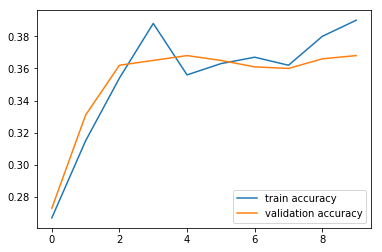

In [126]:
# plot the accuracy history
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [72]:
from ecbm4040.display_funcs import visualize_pics

num of feature vectors: 100


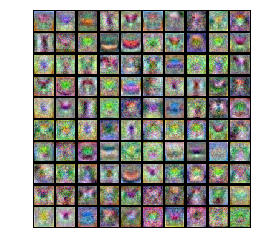

In [127]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
# visualization
visualize_pics(pics)

### Get test accuracy greater than 48%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 48%. If your accuracy is lower, for each 1% lower than 48%, you will lose 1 point. On the other hand, you will get one extra point for every 1% higher than 52%.

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc. For example, if you change SGD into SGD with momentum, then you should get about 2% increase in accuracy.
4. Early-stopping.
5. Good (better) initial values for weights in the model.
6. Try use PCA or other preprocessing methods. (Try task3-dim_reduction.ipynb before finishing this task)

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```
* SGD with momentum
    ```
    v = momentum*v + learning_rate * gradient
    w = w - v
    ```
    
<span style="color:red"><strong>TODO</strong></span>: See below

In [181]:
# TODO
#  from ecbm4040.classifiers.twolayernet import TwoLayerNet

# TODO: Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to below, using your parameter specs
model = TwoLayerNet(input_dim=3072, hidden_dim=150, num_classes=10, reg=0.1, weight_scale=1e-3)
# tune these: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale
num_epoch = 8
batch_size = 800 #
lr = 2e-3 #
verbose = True
ld = 0.95
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, learning_decay=ld, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 61
8000/49000 loss: 2.368242077869117
16000/49000 loss: 2.26164918596579
24000/49000 loss: 2.3243516613699784
32000/49000 loss: 2.674792120760988
40000/49000 loss: 2.288481236208444
48000/49000 loss: 2.205168843893827
epoch 1: valid acc = 0.224, new learning rate = 0.0019
8000/49000 loss: 2.175722005979107
16000/49000 loss: 2.114151139190641
24000/49000 loss: 1.9867631215607249
32000/49000 loss: 1.972804757271183
40000/49000 loss: 1.895005016992521
48000/49000 loss: 1.8090115998311094
epoch 2: valid acc = 0.323, new learning rate = 0.001805
8000/49000 loss: 1.7828067401585017
16000/49000 loss: 1.834991138329173
24000/49000 loss: 1.6674513786623708
32000/49000 loss: 1.71895798152547
40000/49000 loss: 1.730441068096846
48000/49000 loss: 1.6894672649896576
epoch 3: valid acc = 0.363, new learning rate = 0.00171475
8000/49000 loss: 1.6638215606900424
16000/49000 loss: 1.7394556700850345
24000/49000 loss: 1.595964559377342
32000/49000 loss: 1.618144856486848


0.35930000000000001

#### <span style="color:red"><strong>TODO</strong></span>: Show your best result, including accuracy and weights of the first layer

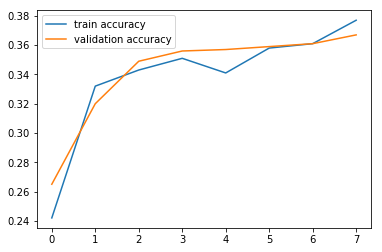

In [160]:
# TODO: plot training and validation accuracy
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

num of feature vectors: 150


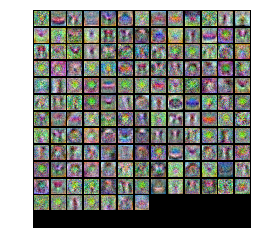

In [161]:
# TODO: Visualize weights
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
# visualization
visualize_pics(pics)

### Save your best model in a dictionary 

In [174]:
# Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [175]:
# Load your model
with open("./save_models/best_model.pkl", "rb") as input_file:
   load_params = pickle.load(input_file)
    
model.update_model(load_params)

## Part 3: Multilayer Net 

Complete the class **MLP** in **./ecbm4040/classifiers/network.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network. Complete the "<span style="color:red"><strong>TODO</strong></span>" part.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

In [182]:
from ecbm4040.classifiers.mlp import MLP

# TODO: Use a sequence of layers to create a multiple layer neural network
# input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 50, 50], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98


ValueError: cannot reshape array of size 25000 into shape (500,3072)

## Part 4: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net. You need to implement a multi-layer with 3 or 4 layers.

In [147]:
# Demo: Two-layer net in tensorflow.
hidden_dim = 100
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
b2_tf = tf.Variable(np.zeros((10,)).astype('float32'))

h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.23800000548362732
epoch 2: valid acc = 0.3540000021457672
epoch 3: valid acc = 0.40700000524520874
epoch 4: valid acc = 0.4320000112056732
epoch 5: valid acc = 0.46000000834465027
epoch 6: valid acc = 0.47600001096725464
epoch 7: valid acc = 0.4869999885559082
epoch 8: valid acc = 0.492000013589859
epoch 9: valid acc = 0.4970000088214874
epoch 10: valid acc = 0.5040000081062317
test acc = 0.5040000081062317


<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" or "dictionary" to store your network parameters, ie., weights and bias. Besides, consider to use a loop to create your MLP network.

In [173]:
# A three-layer MLP network

hidden_dim = 100
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
b2_tf = tf.Variable(np.zeros((10,)).astype('float32'))
W3_tf = tf.Variable(1e-2*np.random.rand(10, 100).astype('float32'))
b3_tf = tf.Variable(np.zeros((100,)).astype('float32'))

h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.add(tf.matmul(h1_tf, W2_tf), b2_tf)
h3_tf = tf.matmul(h2_tf, W3_tf) + b3_tf 


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h3_tf, labels=tf.one_hot(y_tf,100))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf) + tf.nn.l2_loss(W3_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h3_tf,1))
# correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.11999999731779099
epoch 2: valid acc = 0.16099999845027924
epoch 3: valid acc = 0.1589999943971634
epoch 4: valid acc = 0.18799999356269836
epoch 5: valid acc = 0.1679999977350235
epoch 6: valid acc = 0.2720000147819519
epoch 7: valid acc = 0.26499998569488525
epoch 8: valid acc = 0.3050000071525574
epoch 9: valid acc = 0.34299999475479126
epoch 10: valid acc = 0.3529999852180481
test acc = 0.3529999852180481
